# Section 1: Baseline Logo Detector

This notebook implements a baseline logo detection model using YOLOv8, followed by improvements.

## Objectives:
1. Build a baseline detector on the logos dataset
2. Analyze shortcomings
3. Implement improvements
4. Evaluate performance with extensive visualizations


In [30]:
# Import necessary libraries
import os
import json
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from collections import Counter
import yaml
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check device (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


Using device: mps


## 1. Data Exploration and Analysis


In [31]:
# Define paths
DATA_ROOT = Path("raw_data/logos_dataset")
TRAIN_IMAGES = DATA_ROOT / "images" / "train"
TRAIN_LABELS = DATA_ROOT / "labels" / "train"
TEST_IMAGES = DATA_ROOT / "images" / "test"
TEST_LABELS = DATA_ROOT / "labels" / "test"

# Load and analyze dataset
def load_annotations(label_dir):
    """Load all annotations and extract class information"""
    annotations = []
    class_counts = Counter()
    
    for label_file in tqdm(list(label_dir.glob("*.txt")), desc="Loading annotations"):
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_name = parts[0]
                    bbox = [float(x) for x in parts[1:5]]
                    annotations.append({
                        'class': class_name,
                        'bbox': bbox,
                        'file': label_file.name
                    })
                    class_counts[class_name] += 1
    
    return annotations, class_counts

print("Loading training annotations...")
train_annotations, train_class_counts = load_annotations(TRAIN_LABELS)
print(f"\nTraining set: {len(train_annotations)} annotations")
print(f"Number of unique classes: {len(train_class_counts)}")

print("\nLoading test annotations...")
test_annotations, test_class_counts = load_annotations(TEST_LABELS)
print(f"\nTest set: {len(test_annotations)} annotations")
print(f"Number of unique classes: {len(test_class_counts)}")

# Get all unique classes
all_classes = sorted(set(train_class_counts.keys()) | set(test_class_counts.keys()))
print(f"\nTotal unique classes: {len(all_classes)}")
print(f"\nClasses: {', '.join(all_classes[:20])}{'...' if len(all_classes) > 20 else ''}")


Loading training annotations...


Loading annotations: 100%|██████████| 937/937 [00:00<00:00, 7185.09it/s]



Training set: 2508 annotations
Number of unique classes: 5

Loading test annotations...


Loading annotations: 100%|██████████| 137/137 [00:00<00:00, 11905.76it/s]


Test set: 300 annotations
Number of unique classes: 5

Total unique classes: 5

Classes: fedex, nike, puma, sap, spotify


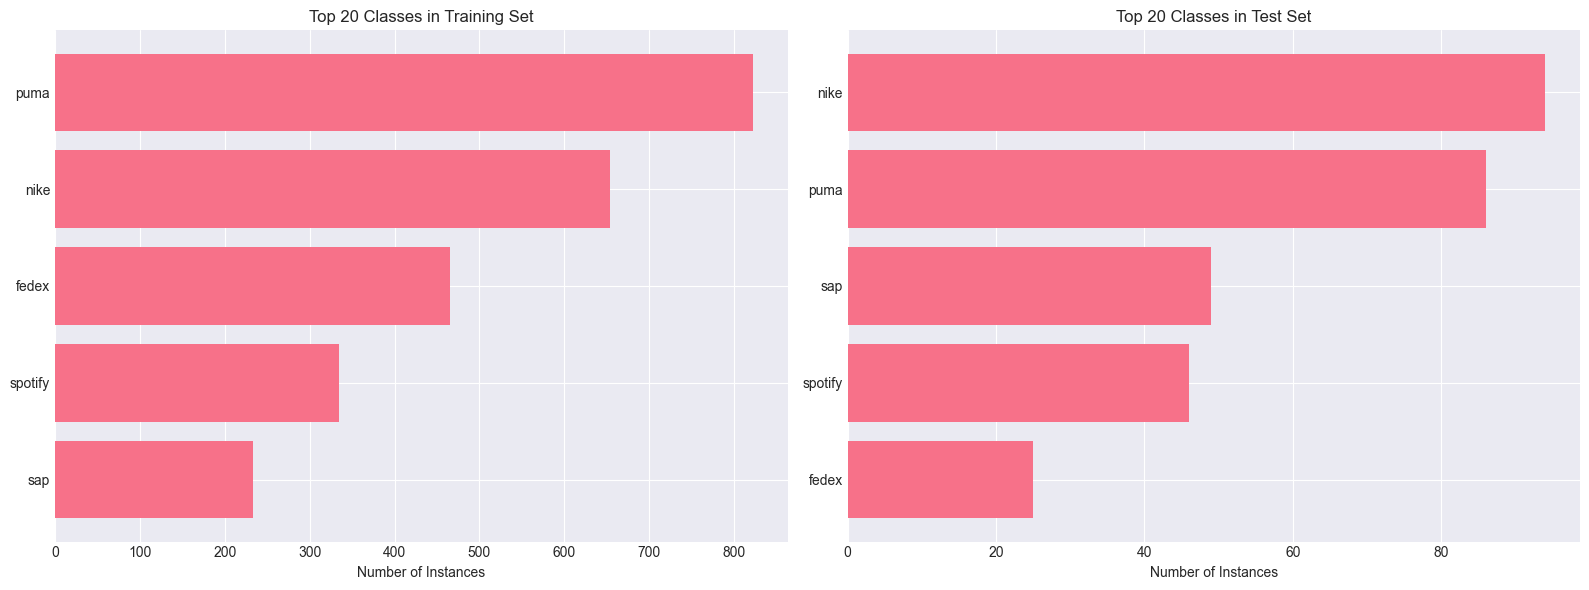


Training set statistics:
  Total images: 937
  Total annotations: 2508
  Average annotations per image: 2.68

Test set statistics:
  Total images: 137
  Total annotations: 300
  Average annotations per image: 2.19


In [32]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
train_top_classes = dict(train_class_counts.most_common(20))
axes[0].barh(range(len(train_top_classes)), list(train_top_classes.values()))
axes[0].set_yticks(range(len(train_top_classes)))
axes[0].set_yticklabels(list(train_top_classes.keys()))
axes[0].set_xlabel('Number of Instances')
axes[0].set_title('Top 20 Classes in Training Set')
axes[0].invert_yaxis()

# Test set
test_top_classes = dict(test_class_counts.most_common(20))
axes[1].barh(range(len(test_top_classes)), list(test_top_classes.values()))
axes[1].set_yticks(range(len(test_top_classes)))
axes[1].set_yticklabels(list(test_top_classes.keys()))
axes[1].set_xlabel('Number of Instances')
axes[1].set_title('Top 20 Classes in Test Set')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nTraining set statistics:")
print(f"  Total images: {len(list(TRAIN_IMAGES.glob('*.jpg')))}")
print(f"  Total annotations: {len(train_annotations)}")
print(f"  Average annotations per image: {len(train_annotations) / len(list(TRAIN_IMAGES.glob('*.jpg'))):.2f}")

print(f"\nTest set statistics:")
print(f"  Total images: {len(list(TEST_IMAGES.glob('*.jpg')))}")
print(f"  Total annotations: {len(test_annotations)}")
print(f"  Average annotations per image: {len(test_annotations) / len(list(TEST_IMAGES.glob('*.jpg'))):.2f}")


Sample training images:


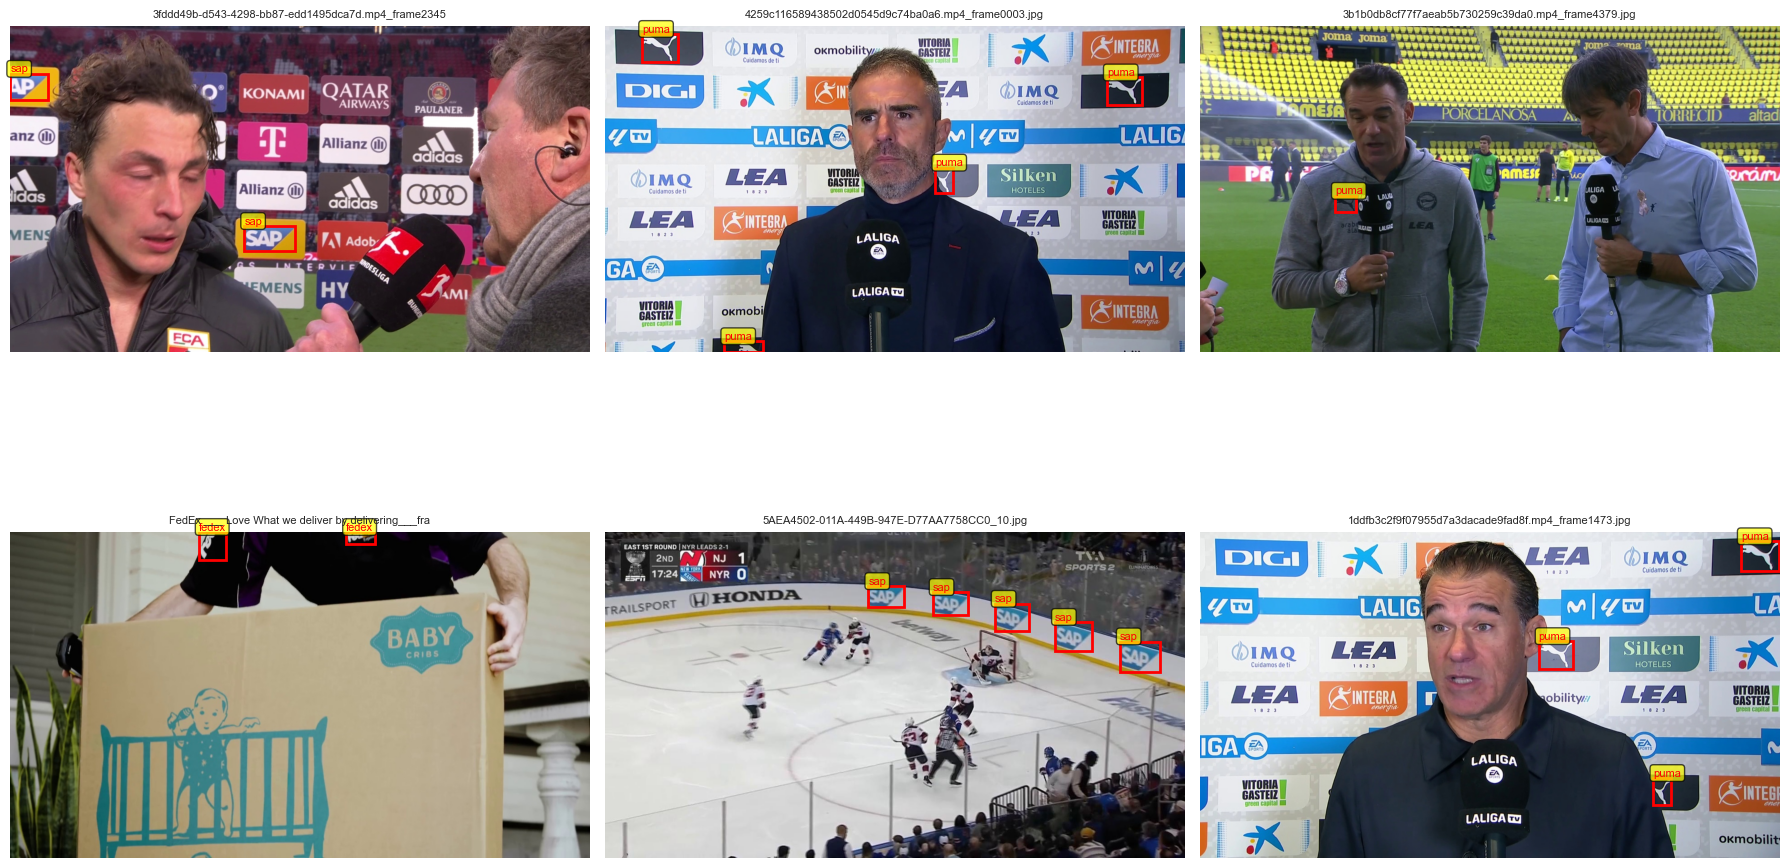

In [33]:
# Visualize sample images with bounding boxes
def visualize_sample(image_path, label_path, num_samples=6):
    """Visualize sample images with their bounding boxes"""
    image_files = list(image_path.glob("*.jpg"))[:num_samples]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(image_files):
        # Load image
        img = Image.open(img_file)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(img_file.name[:50], fontsize=8)
        
        # Load and draw bounding boxes
        label_file = label_path / (img_file.stem + ".txt")
        if label_file.exists():
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_name = parts[0]
                        x_center, y_center, width, height = [float(x) for x in parts[1:5]]
                        
                        # Convert normalized coordinates to pixel coordinates
                        img_width, img_height = img.size
                        x = (x_center - width/2) * img_width
                        y = (y_center - height/2) * img_height
                        w = width * img_width
                        h = height * img_height
                        
                        # Draw bounding box
                        from matplotlib.patches import Rectangle
                        rect = Rectangle((x, y), w, h, linewidth=2, 
                                        edgecolor='red', facecolor='none')
                        axes[idx].add_patch(rect)
                        axes[idx].text(x, y-5, class_name, color='red', fontsize=8, 
                                      bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

print("Sample training images:")
visualize_sample(TRAIN_IMAGES, TRAIN_LABELS)


## 2. Prepare YOLO Dataset Format


In [34]:
# Create YOLO dataset structure
YOLO_DATASET = Path("yolo_dataset")
YOLO_DATASET.mkdir(exist_ok=True)

# Create directories
for split in ['train', 'val', 'test']:
    (YOLO_DATASET / split / 'images').mkdir(parents=True, exist_ok=True)
    (YOLO_DATASET / split / 'labels').mkdir(parents=True, exist_ok=True)

# Split training data into train/val (80/20)
train_image_files = list(TRAIN_IMAGES.glob("*.jpg"))
np.random.shuffle(train_image_files)
split_idx = int(0.8 * len(train_image_files))
train_files = train_image_files[:split_idx]
val_files = train_image_files[split_idx:]

print(f"Train split: {len(train_files)} images")
print(f"Val split: {len(val_files)} images")
print(f"Test split: {len(list(TEST_IMAGES.glob('*.jpg')))} images")

# Copy files to YOLO format
def copy_yolo_files(image_files, image_dir, label_dir, target_split):
    """Copy images and labels to YOLO format"""
    for img_file in tqdm(image_files, desc=f"Copying {target_split} files"):
        # Copy image
        shutil.copy(img_file, YOLO_DATASET / target_split / 'images' / img_file.name)
        
        # Copy and convert label (YOLO format uses class index, not name)
        label_file = label_dir / (img_file.stem + ".txt")
        if label_file.exists():
            # Read original label
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            # Write YOLO format (convert class name to index)
            with open(YOLO_DATASET / target_split / 'labels' / label_file.name, 'w') as f:
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_name = parts[0]
                        if class_name in all_classes:
                            class_idx = all_classes.index(class_name)
                            f.write(f"{class_idx} {' '.join(parts[1:5])}\n")

# Copy training files
copy_yolo_files(train_files, TRAIN_IMAGES, TRAIN_LABELS, 'train')
copy_yolo_files(val_files, TRAIN_IMAGES, TRAIN_LABELS, 'val')

# Copy test files
test_image_files = list(TEST_IMAGES.glob("*.jpg"))
copy_yolo_files(test_image_files, TEST_IMAGES, TEST_LABELS, 'test')

print("\nYOLO dataset structure created!")


Train split: 749 images
Val split: 188 images
Test split: 137 images


Copying test files: 100%|██████████| 137/137 [00:00<00:00, 1024.24it/s]


YOLO dataset structure created!


In [35]:
# Create YOLO dataset configuration file
dataset_config = {
    'path': str(YOLO_DATASET.absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': len(all_classes),
    'names': all_classes
}

config_path = YOLO_DATASET / 'dataset.yaml'
with open(config_path, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"Dataset config saved to: {config_path}")
print(f"\nDataset configuration:")
print(f"  Number of classes: {len(all_classes)}")
print(f"  Classes: {all_classes}")


Dataset config saved to: yolo_dataset/dataset.yaml

Dataset configuration:
  Number of classes: 5
  Classes: ['fedex', 'nike', 'puma', 'sap', 'spotify']


## 3. Baseline Model: YOLO 11


In [36]:
# Install ultralytics if not already installed
try:
    from ultralytics import YOLO
    print("Ultralytics already installed")
except ImportError:
    print("Installing ultralytics...")
    import subprocess
    subprocess.check_call(["pip", "install", "ultralytics"])
    from ultralytics import YOLO

# Initialize baseline YOLOv8 model (nano version for faster training)
print("Initializing YOLOv8 baseline model...")
baseline_model = YOLO('yolo11n.pt')  # nano version - smallest and fastest

print(f"Model initialized. Device: {device}")
print(f"Number of classes: {len(all_classes)}")


Ultralytics already installed
Initializing YOLOv8 baseline model...
Model initialized. Device: mps
Number of classes: 5


In [37]:
# Train baseline model
print("Starting baseline model training...")
print(f"Dataset config: {config_path}")

# Training parameters optimized for MPS
baseline_results = baseline_model.train(
    data=str(config_path),
    epochs=25,  # Start with 50 epochs
    imgsz=640,
    batch=16,  # Adjust based on available memory
    device=str(device),
    project='runs/detect',
    name='baseline',
    exist_ok=True,
    patience=5,  # Early stopping
    save=True,
    plots=True,
    verbose=True,
    box=7.5,    # Increase weight of box loss (default is usually 7.5)
    cls=0.5,    # Weight of classification loss (default 0.5)
    dfl=1.5,    # Weight of distribution focal loss (default 1.5)
)

print("\nBaseline training completed!")
print(f"Results saved to: {baseline_results.save_dir}")


Starting baseline model training...
Dataset config: yolo_dataset/dataset.yaml
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.1 MPS (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

In [38]:
# Load the best model
baseline_best = YOLO(baseline_results.save_dir / 'weights' / 'best.pt')

# Evaluate on validation set
print("Evaluating baseline model on validation set...")
val_metrics = baseline_best.val(data=str(config_path), split='val')
print(f"\nValidation mAP50: {val_metrics.box.map50:.4f}")
print(f"Validation mAP50-95: {val_metrics.box.map:.4f}")

# Evaluate on test set
print("\nEvaluating baseline model on test set...")
test_metrics = baseline_best.val(data=str(config_path), split='test')
print(f"\nTest mAP50: {test_metrics.box.map50:.4f}")
print(f"Test mAP50-95: {test_metrics.box.map:.4f}")

# Save metrics
baseline_metrics = {
    'val_map50': float(val_metrics.box.map50),
    'val_map50_95': float(val_metrics.box.map),
    'test_map50': float(test_metrics.box.map50),
    'test_map50_95': float(test_metrics.box.map)
}

with open('baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print("\nMetrics saved to baseline_metrics.json")


Evaluating baseline model on validation set...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 846.7±284.0 MB/s, size: 363.8 KB)
val: Scanning /Users/yanivz/Documents/code/sports/logo/logos_detector/yolo_dataset/val/labels.cache... 188 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 188/188 796.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.1s/it 25.2s2.2s
                   all        188        458      0.943      0.863      0.925      0.804
                 fedex         39         92      0.973      0.795      0.928      0.776
                  nike         55        108      0.962      0.796      0.864      0.756
                  puma         40        117      0.924      0.812      0.894      0.726
                   sap         27         68      0

## 4. Visualize Training Results


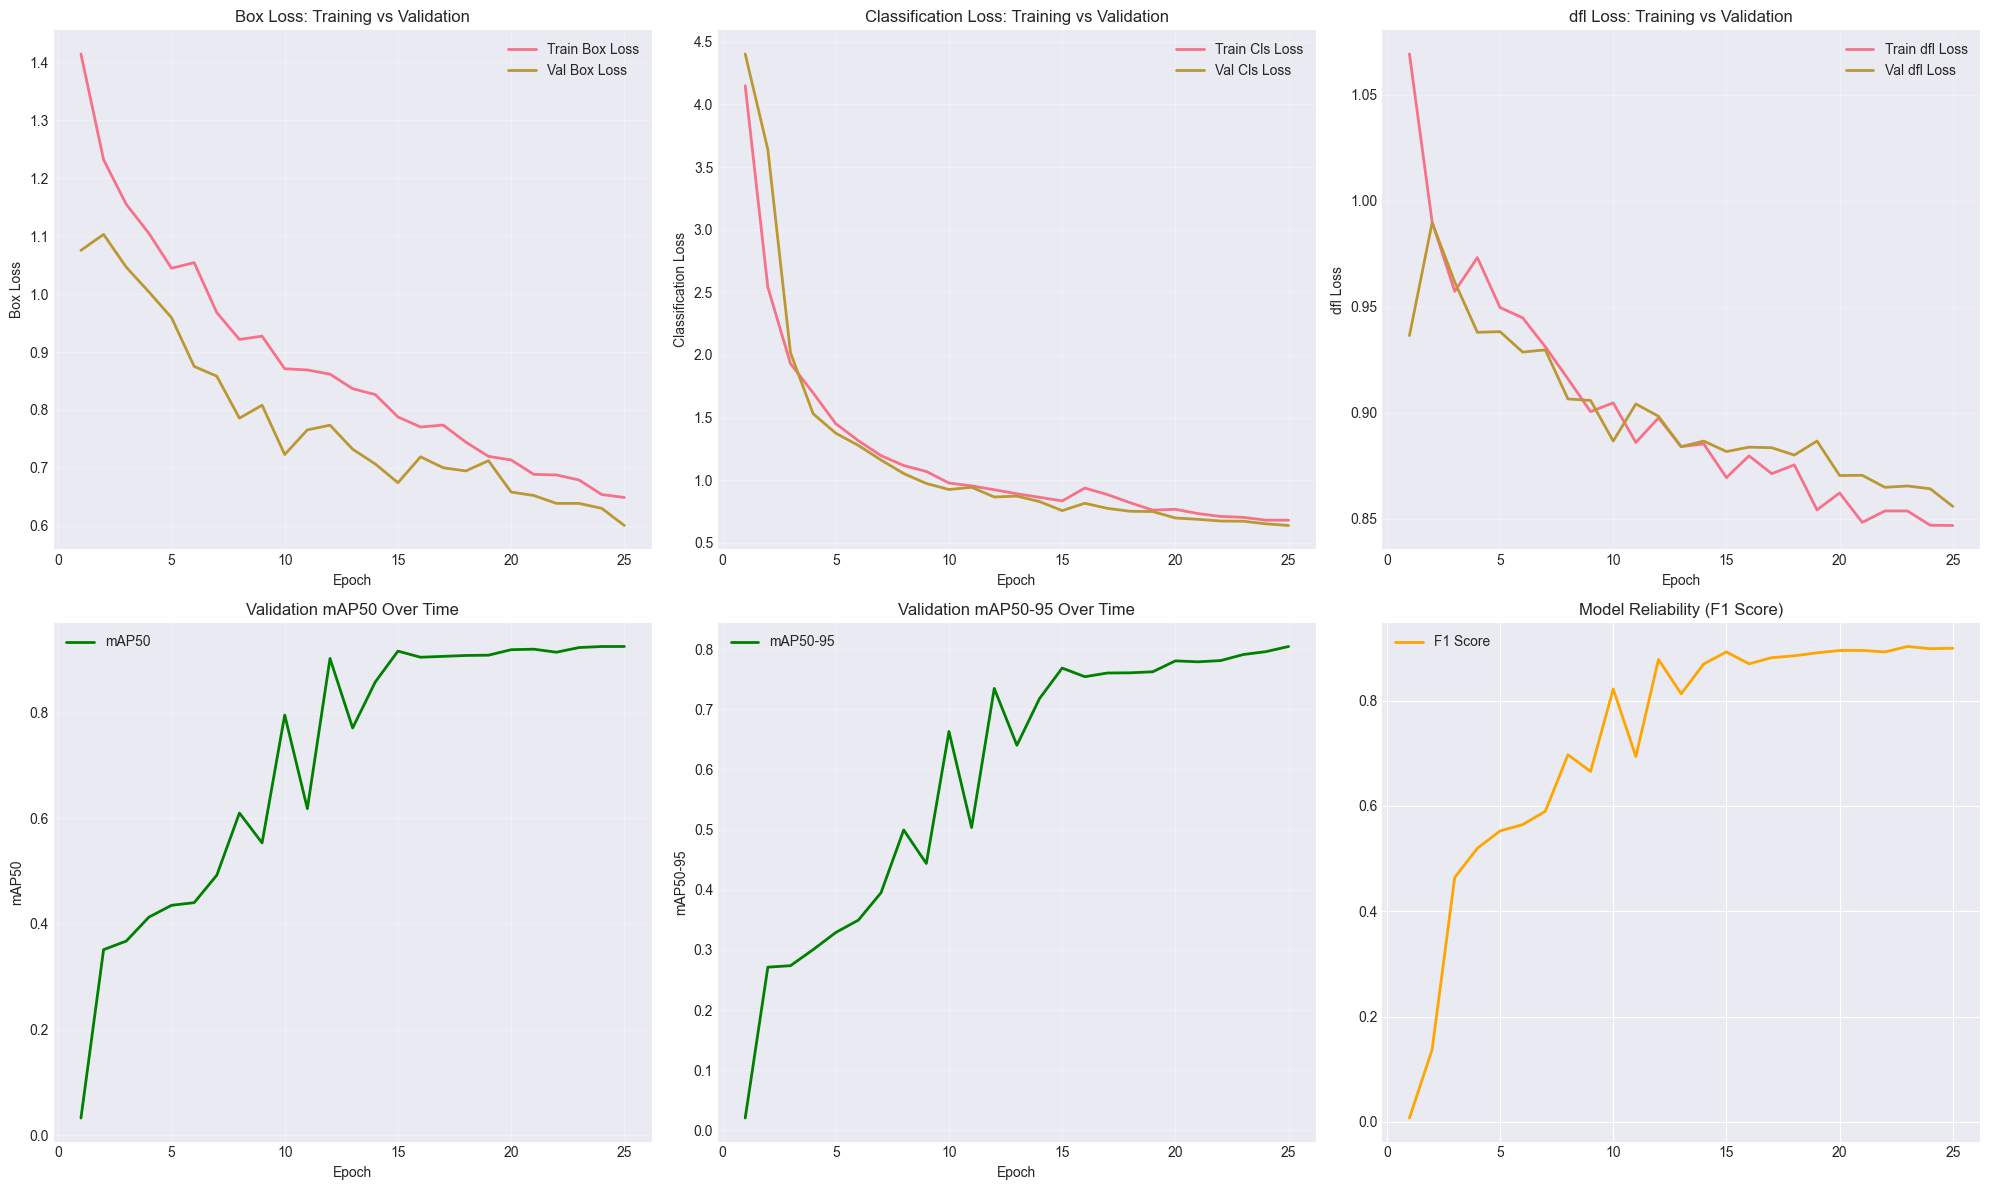

Training curves saved to baseline_training_curves.png


In [40]:
# Load training results
results_csv = baseline_results.save_dir / 'results.csv'
if results_csv.exists():
    import pandas as pd
    results_df = pd.read_csv(results_csv)
    
    # Plot training and validation losses
    #fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fix, axes = plt.subplots(2, 3, figsize=(20, 12))
    # Box loss
    axes[0, 0].plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss', linewidth=2)
    axes[0, 0].plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Box Loss')
    axes[0, 0].set_title('Box Loss: Training vs Validation')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # # Objectness loss
    # axes[0, 1].plot(results_df['epoch'], results_df['train/obj_loss'], label='Train Obj Loss', linewidth=2)
    # axes[0, 1].plot(results_df['epoch'], results_df['val/obj_loss'], label='Val Obj Loss', linewidth=2)
    # axes[0, 1].set_xlabel('Epoch')
    # axes[0, 1].set_ylabel('Objectness Loss')
    # axes[0, 1].set_title('Objectness Loss: Training vs Validation')
    # axes[0, 1].legend()
    # axes[0, 1].grid(True, alpha=0.3)


    # mAP50-95
    axes[1, 1].plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95', linewidth=2, color='green')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('mAP50-95')
    axes[1, 1].set_title('Validation mAP50-95 Over Time')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Classification loss
    axes[0, 1].plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Cls Loss', linewidth=2)
    axes[0, 1].plot(results_df['epoch'], results_df['val/cls_loss'], label='Val Cls Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Classification Loss')
    axes[0, 1].set_title('Classification Loss: Training vs Validation')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    #train/dfl_loss
    axes[0, 2].plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train dfl Loss', linewidth=2)
    axes[0, 2].plot(results_df['epoch'], results_df['val/dfl_loss'], label='Val dfl Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('dfl Loss')
    axes[0, 2].set_title('dfl Loss: Training vs Validation')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # mAP50
    axes[1, 0].plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50', linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('mAP50')
    axes[1, 0].set_title('Validation mAP50 Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    

    results_df['metrics/F1(B)'] = 2 * (results_df['metrics/precision(B)'] * results_df['metrics/recall(B)']) / \
                                 (results_df['metrics/precision(B)'] + results_df['metrics/recall(B)'] + 1e-6)

    # Add this to your plotting loop or as a new subplot
    axes[1, 2].plot(results_df['epoch'], results_df['metrics/F1(B)'], label='F1 Score', color='orange', linewidth=2)
    axes[1, 2].set_title('Model Reliability (F1 Score)')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.savefig('baseline_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Training curves saved to baseline_training_curves.png")
else:
    print("Results CSV not found. Training may still be in progress.")



0: 640x640 4 saps, 62.6ms
1: 640x640 1 nike, 62.6ms
2: 640x640 2 nikes, 1 puma, 1 sap, 62.6ms
3: 640x640 2 saps, 62.6ms
4: 640x640 2 saps, 62.6ms
5: 640x640 1 sap, 62.6ms
6: 640x640 1 nike, 1 spotify, 62.6ms
7: 640x640 1 nike, 62.6ms
8: 640x640 1 nike, 62.6ms
9: 640x640 2 saps, 62.6ms
10: 640x640 1 nike, 62.6ms
11: 640x640 (no detections), 62.6ms
Speed: 2.4ms preprocess, 62.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


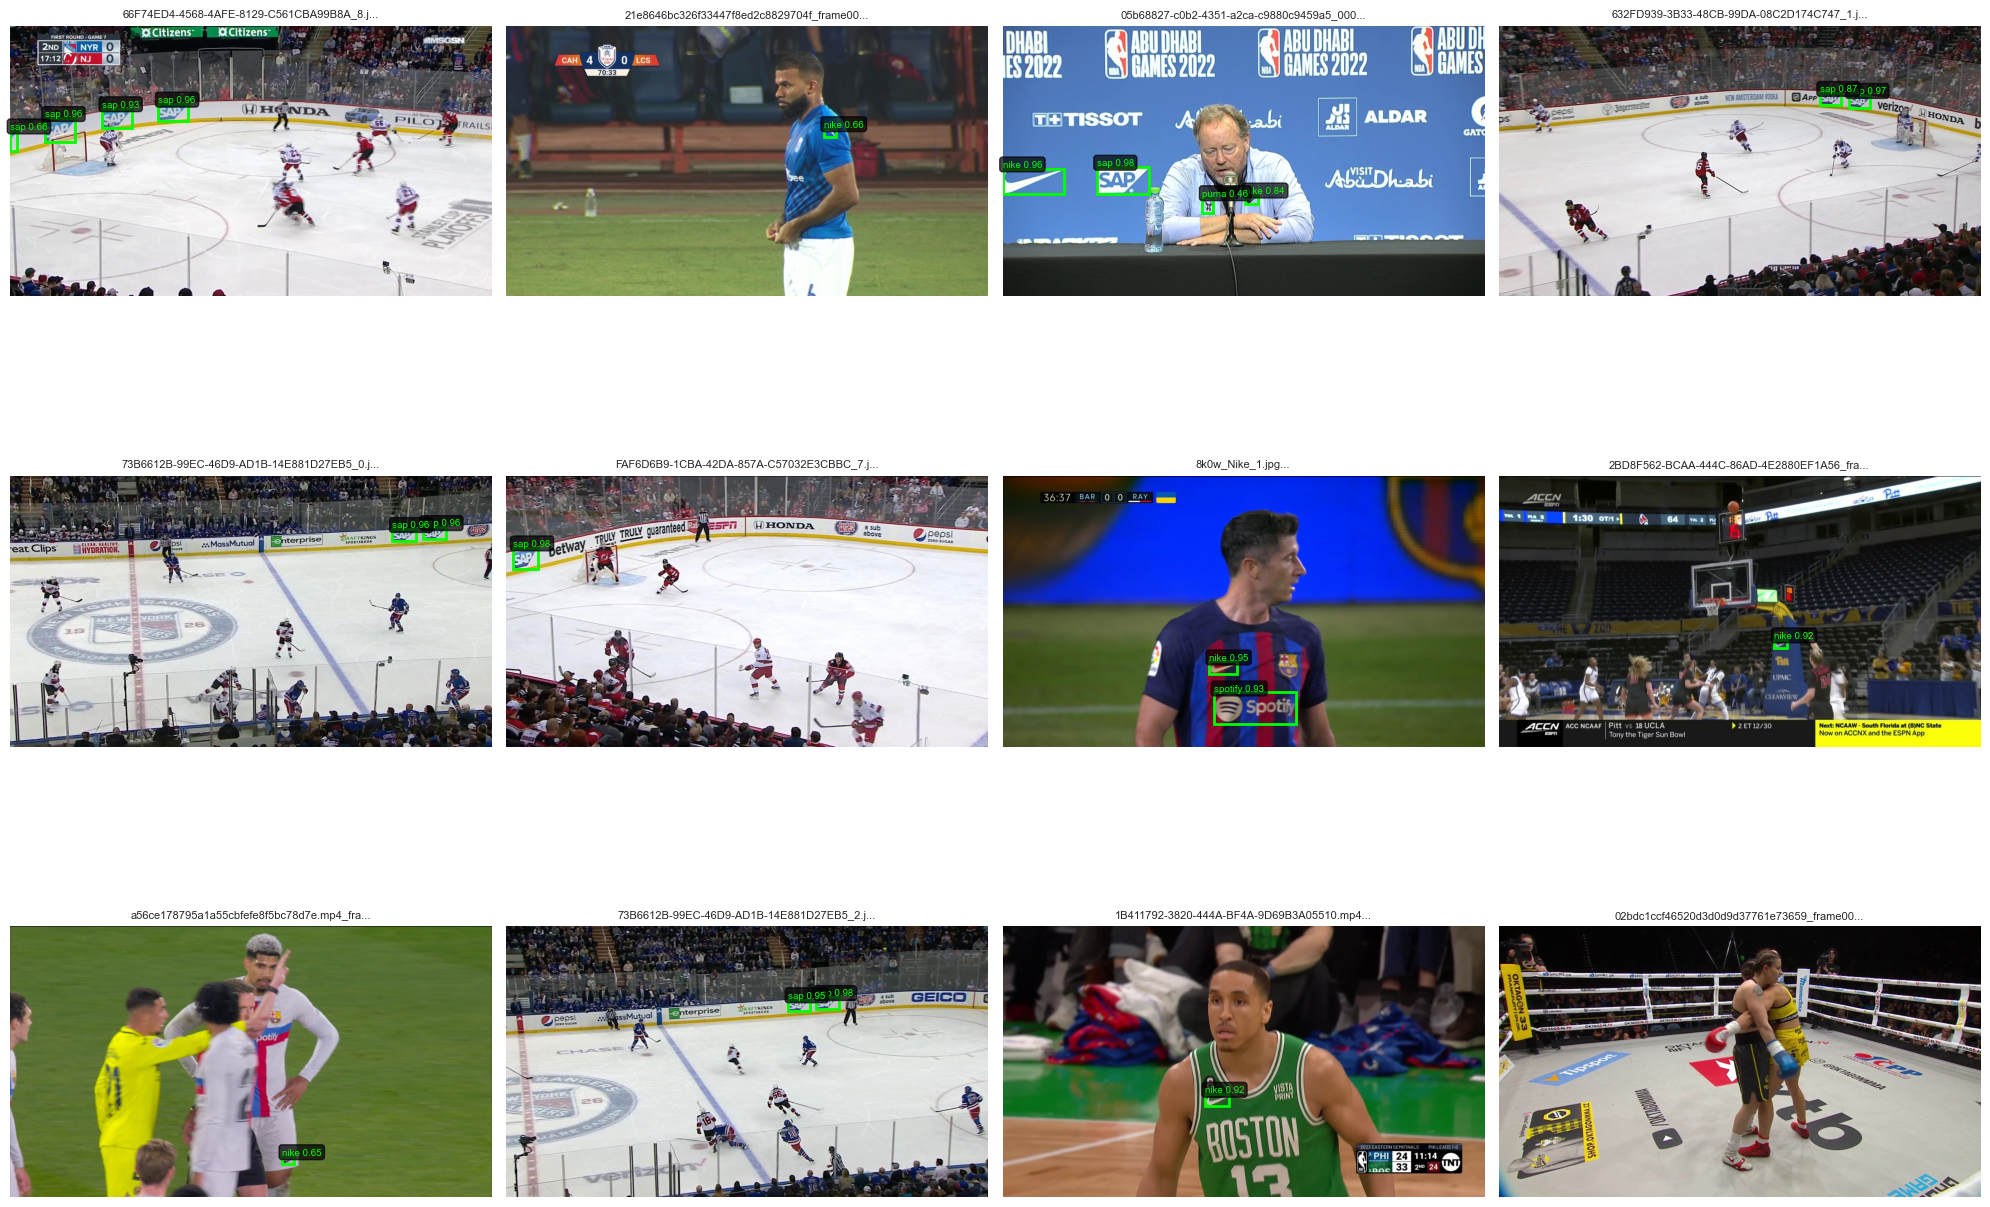

Test predictions saved to baseline_test_predictions.png


In [42]:
# Run predictions on test images
test_image_files = list((YOLO_DATASET / 'test' / 'images').glob("*.jpg"))[:12]

# Get predictions
predictions = baseline_best.predict(
    source=[str(f) for f in test_image_files],
    conf=0.25,
    iou=0.45,
    save=False,
    show=False
)

# Visualize predictions
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, (img_file, pred) in enumerate(zip(test_image_files, predictions)):
    # Load original image
    img = Image.open(img_file)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"{img_file.name[:40]}...", fontsize=8)
    
    # Draw predictions
    if pred.boxes is not None and len(pred.boxes) > 0:
        boxes = pred.boxes.xyxy.cpu().numpy()
        confidences = pred.boxes.conf.cpu().numpy()
        classes = pred.boxes.cls.cpu().numpy().astype(int)
        
        for box, conf, cls in zip(boxes, confidences, classes):
            x1, y1, x2, y2 = box
            class_name = all_classes[cls]
            
            # Draw bounding box
            from matplotlib.patches import Rectangle
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                           edgecolor='lime', facecolor='none')
            axes[idx].add_patch(rect)
            axes[idx].text(x1, y1-5, f"{class_name} {conf:.2f}", 
                          color='lime', fontsize=7,
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.savefig('baseline_test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Test predictions saved to baseline_test_predictions.png")


## 6. Baseline Model Analysis

### Shortcomings Identified:
1. **Model Size**: Using YOLOv8n (nano) - smallest model may lack capacity
2. **Data Augmentation**: Limited or default augmentation
3. **Hyperparameters**: Using default learning rate and other hyperparameters
4. **Class Imbalance**: Some classes have many more instances than others
5. **Image Resolution**: Fixed 640x640 may not be optimal
6. **Training Epochs**: May need more epochs for convergence

### Proposed Improvements:
1. Use larger YOLOv8 model (small or medium)
2. Enhanced data augmentation
3. Hyperparameter tuning
4. Class balancing techniques
5. Multi-scale training
6. Longer training with learning rate scheduling


In [41]:
# Save baseline model path for next notebook
baseline_model_path = str(baseline_results.save_dir / 'weights' / 'best.pt')
print(f"Baseline model saved at: {baseline_model_path}")

# Save important information for next notebook
baseline_info = {
    'model_path': baseline_model_path,
    'classes': all_classes,
    'num_classes': len(all_classes),
    'metrics': baseline_metrics,
    'dataset_config': str(config_path)
}

with open('baseline_info.json', 'w') as f:
    json.dump(baseline_info, f, indent=2)

print("\nBaseline information saved to baseline_info.json")
print("\n" + "="*50)
print("BASELINE MODEL COMPLETE")
print("="*50)
print(f"Validation mAP50: {baseline_metrics['val_map50']:.4f}")
print(f"Test mAP50: {baseline_metrics['test_map50']:.4f}")


Baseline model saved at: /Users/yanivz/Documents/code/sports/logo/logos_detector/runs/detect/baseline/weights/best.pt

Baseline information saved to baseline_info.json

BASELINE MODEL COMPLETE
Validation mAP50: 0.9250
Test mAP50: 0.9417
